# The Pulse of Berlin


## Introduction

According to  U.S.~Small Business Association, approximately 50% of new businesses fail within five years of opening. Given the high risk and challenging retail environment, finding the right target demographic and business environment is therefore key. At the same time, cities are becoming increasingly dynamic and diverse which provides ample opportunities for business segmentation. 

Combining data-science approaches with the increasing availability of real time consumer data and open data from city governments can provide valuable insight that can businesses help attract and retain customers.  


## Question

Berlin, the capital of Germany, is home to approximately 3.6 million people and widely recognized to be one of Europe's most dynamic cities. 

Using the city of Berlin as example, we segment its districts by their population demographics and analyze what type of businesses thrive is the respective neighborhoods. The _trending_ feature of the Foursquare API, we analyze locations and neighborhoods in Berlin that are trending within a 24-h window letting us experience the _Pulse of the City_.


In detail we ask:
- Which neighborhoods have the highest density of trending venues?
- Does the age distribution of district residents have a discernible impact on venues density and type?
- Can we segment neighborhoods based on the type of business venues they attract and is there a relationship to the demographics Berlin's districts?  


## Analytical Approach 

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import numpy as np
import os
#! pip install wget
import wget
!pip install pyproj
import pyproj
import folium
import json
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
#!conda install shapely
from shapely.geometry import shape, Point

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import datetime

### Berlin demographics data
We download demongraphic data from [Berlin Open Data Portal](https://daten.berlin.de/datensaetze/einwohnerinnen-texttt{und-einwohner-den-ortsteilen-berlins-am-30062016). The dataset contains population number broken down by age-cohort and city sub-district. 

In [487]:
import os 
import pandas as pd
import wget 

scriptdir = os.getcwd()
filename = 'EWR_Ortsteile_2016-06-30.csv'
relpath = 'Data'

path = os.path.join(scriptdir, relpath, filename)
# see if data is already downloaded, if not download
try:
    df = pd.read_csv(path, encoding='latin-1', sep = ';')
except:
    wget.download("https://www.statistik-berlin-brandenburg.de/opendata/EWR_Ortsteile_2016-06-30.csv",
                 out=os.path.join(scriptdir, relpath))
    df = pd.read_csv(path, encoding='latin-1', sep = ';')
    #df_dem

df.dtypes

Bezirk          int64
Bez-Name       object
Ortsteil        int64
Ortst-Name     object
Geschl          int64
Staatsangeh    object
Altersgr       object
Häufigkeit      int64
dtype: object

We aggregate the data to the district level per age group. Translating columns into English along the way

In [488]:
df_dem = df[['Bez-Name','Häufigkeit','Altersgr']].groupby(['Bez-Name', 'Altersgr']).sum().reset_index()
df_dem=df_dem.rename(columns = {'Bez-Name': 'District', 'Altersgr': 'AgeGroup', 'Häufigkeit' : 'Population'} )
df_dem.head(10)

District AgeGroup  Population
0  Charlottenburg-Wilmersdorf    00_05       13290
1  Charlottenburg-Wilmersdorf    05_10       12101
2  Charlottenburg-Wilmersdorf    10_15       11395
3  Charlottenburg-Wilmersdorf    15_20       12328
4  Charlottenburg-Wilmersdorf    20_25       18118
5  Charlottenburg-Wilmersdorf    25_30       25022
6  Charlottenburg-Wilmersdorf    30_35       24254
7  Charlottenburg-Wilmersdorf    35_40       22437
8  Charlottenburg-Wilmersdorf    40_45       20991
9  Charlottenburg-Wilmersdorf    45_50       24791

The demographic age groups are pretty fine grained and are aggregated to something a bit more _generational_

In [489]:
import numpy as np
df=df.rename(columns = {'Bez-Name': 'District', 'Altersgr': 'AgeGroup', 'Häufigkeit' : 'Population'} )
df_dem = pd.pivot_table(df[['District','Population','AgeGroup']], values='Population', index=['District'],columns=['AgeGroup'],aggfunc=np.sum)
df_dem.columns[0:3]
df_dem['0-15'] = df_dem[df_dem.columns[0:3]].sum(axis = 1)
df_dem['15-30'] = df_dem[df_dem.columns[3:6]].sum(axis = 1)
df_dem['30-50'] = df_dem[df_dem.columns[6:10]].sum(axis = 1)
df_dem['50-65'] = df_dem[df_dem.columns[10:13]].sum(axis = 1)
df_dem['>65'] = df_dem[df_dem.columns[13:20]].sum(axis = 1)
df_dem['Total'] = df_dem[df_dem.columns[1:20]].sum(axis = 1)

#df_dem['Senior'] = df_dem[['15_20','20_25' ,'25_30']].sum(axis = 1)
df_dem=df_dem[['0-15','15-30','30-50','50-65','>65','Total']]
df_dem

AgeGroup                     0-15  15-30   30-50  50-65    >65   Total
District                                                              
Charlottenburg-Wilmersdorf  36786  55468   92473  72484  77124  321045
Friedrichshain-Kreuzberg    36943  61001  111795  43344  27993  265903
Lichtenberg                 37747  51450   80893  55207  55424  265762
Marzahn-Hellersdorf         37236  42043   66718  67071  48886  248323
Mitte                       48760  86902  122995  61261  48204  349199
Neukölln                    44075  65789  100401  60155  57625  311462
Pankow                      58786  63553  143907  69218  59352  372086
Reinickendorf               35930  43676   63644  54959  62044  248073
Spandau                     33528  42010   60366  49526  52848  226631
Steglitz-Zehlendorf         38732  46042   74803  65097  77855  290136
Tempelhof-Schöneberg        43390  60065   96219  73682  71668  329608
Treptow-Köpenick            32930  39901   72366  53368  59217  245346

Setting the population demographics in relation to the total population per district, we can compare the age structure between Berlin's districts. 
For example _Friedrichshain-Kreuzberg_ is much younger than _Steglitz-Zehlendorf_.

In [496]:
import seaborn as sns
# Set colormap equal to seaborns light green color palette
cm = sns.light_palette("green", as_cmap=True)

df_dem_rel = df_dem[['0-15','15-30','30-50','50-65','>65']].div(df_dem['Total'], axis=0).round(2)
df_dem_rel


(df_dem_rel.style
  .background_gradient(cmap='RdBu_r', subset=['0-15','15-30','30-50','50-65','>65']))

Create a simple map with the district borders of Berlin. The data can be downloaded from the [Berlin Technology foundation](https://data.technologiestiftung-berlin.de/dataset/bezirksgrenzen). I downloaded the data to _Data/bezirksgrenzen.json_. For some reason wget did not work.

In [408]:
import folium
# https://data.technologiestiftung-berlin.de/dataset/bezirksgrenzen

berlin_json = r'./Data/bezirksgrenzen.geojson' # geojson file

# create a plain world map
map_berlin = folium.Map(location=[52.5200, 13.4050], zoom_start=10)


folium.GeoJson(
    berlin_json,
    name='geojson'
    ).add_to(map_berlin)

map_berlin
map_berlin.save(r'./Figures/map.html')


In [409]:
#!conda install -c conda-forge selenium 
import selenium.webdriver
import time 
browser = selenium.webdriver.Firefox(executable_path=r'./geckodriver.exe')
browser.get(r'file:///C:/Users/tobia/OneDrive%20-%20Montana%20State%20University%20-%20Bozeman/DataSci/Training/Coursera_DataScienceIBM/9_Capstone/Figures/map.html')
#Give the map tiles some time to load
delay=5
time.sleep(delay)
browser.save_screenshot(r'./Figures/map.png')
browser.quit()



In [7]:
#import imgkit
#imgkit.from_file(r'./Figures/map.html', 'out.jpg')


We can also visualize the total population per district on a Map:

In [410]:
map_berlin_pop = folium.Map(location=[52.5200, 13.4050], zoom_start=10)
map_berlin_pop.choropleth(
    geo_data=berlin_json,
    data=df_dem.reset_index(),
    columns=['District', 'Total'],
    key_on='feature.properties.Gemeinde_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Berlin Population',
    threshold_scale=[200000,250000,300000,350000,400000]
)
map_berlin_pop.save(r'./Figures/map_pop.html')
map_berlin_pop

### Foursquare

Next we get the center coordinates for **Berlin** and subsquently create a sampling grid, which we will be using to query the _Foursquare API_. For this we need to convert UTM coordinates, which have form (x,y) in m to Lat/Lon coordinates. 

*Note this code was inspired by project an example given in the course:*
[Example Notebook](https://cocl.us/coursera_capstone_notebook)

In [411]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
address = 'Berlin Germany'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
berlin = [location.latitude, location.longitude]


In [412]:
import pyproj

def lonlat2xy(lat,lon):
    proj_coord = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_coord, proj_xy, lon,lat)
    return xy[0], xy[1]
    
def xy2lonlat(x,y):
    proj_coord = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    coord = pyproj.transform(proj_xy, proj_coord, x, y)
    return coord[0], coord[1]

# convert Berlon Coordinates
x, y = lonlat2xy(berlin[0], berlin[1])
lon, lat = xy2lonlat(x,y)
print('Berlin center coordinate, Lon= {}; Lat= {}'.format(berlin[1], berlin[0]))
print('Berlin center transform to UTM, X= {}; Y= {}'.format(x,y))
print('Berlin center reverse transform, Lon= {}; Lat= {}'.format(lon, lat))


Berlin center coordinate, Lon= 13.3888599; Lat= 52.5170365
Berlin center transform to UTM, X= 390676.87103088724; Y= 5819766.874314443
Berlin center reverse transform, Lon= 13.3888599; Lat= 52.5170365


We chose here an (x,y) grid of 2km spacing and then cull the grid to make sure that all points are within the Berlin city limits

In [413]:
x_center, y_center = lonlat2xy(berlin[0], berlin[1])
XX = np.arange(-20,26,1)*1000 + x_center
YY = np.arange(20,-21,-1)*1000 + y_center

In [414]:
Lats =[]
Lons = []

for y in YY:
    for x in XX:
        lon, lat =xy2lonlat(x,y)
        Lats.append(lat)
        Lons.append(lon)
                
    

In [416]:
import json
from shapely.geometry import shape, Point

df_points = pd.DataFrame(columns = ['Latitude','Longitude', 'District'])

#with open(berlin_json)
with open(berlin_json, encoding = 'utf-8') as json_file:  
    js = json.load(json_file)
    
map_berlin = folium.Map(location=[52.5200, 13.4050], zoom_start=10)
folium.GeoJson(
    berlin_json,
    name='geojson'
).add_to(map_berlin)



for lon, lat in zip(Lons ,Lats):
    point = Point(lon, lat)
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        #print(feature['properties']['Gemeinde_name'])
        if polygon.contains(point):
            #print(feature['properties']['Gemeinde_name'])
            df_points = df_points.append({'Latitude': lat, 'Longitude': lon, 'District':feature['properties']['Gemeinde_name'] 
                                         }, ignore_index=True)

            folium.features.CircleMarker(
                [lat, lon],
                radius=2, # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                fill_color='yellow',
                popup = 'Lat={:5.2f}; Lon={:5.2f}'.format(lat, lon),
                fill_opacity=0.9
            ).add_to(map_berlin)
            
map_berlin.save(r'./Figures/map_grid.html')
map_berlin



These points are then used for the foursquare analysis. I am saving them to file, so that I don't have to redo the above steps all the time

In [14]:
DoPickle = False
df_points=df_points.sort_values(by = 'District').reset_index()
df_points=df_points[['Latitude','Longitude', 'District']]
if DoPickle:
    df_points.to_pickle(r'./Data/Points.pkl')
df_points.head()

Latitude  Longitude                    District
0  52.533560  13.285047  Charlottenburg-Wilmersdorf
1  52.488415  13.272075  Charlottenburg-Wilmersdorf
2  52.488629  13.286795  Charlottenburg-Wilmersdorf
3  52.488841  13.301516  Charlottenburg-Wilmersdorf
4  52.489052  13.316237  Charlottenburg-Wilmersdorf

Reading in my Foursquare Credentials 

In [15]:
KEY= pd.read_csv('Foursquare_Key.csv')
VERSION = '20180605'
CLIENT_ID = KEY.iloc[0,0]
CLIENT_SECRET = KEY.iloc[0,1]

### Retrieving Foursquare data
Getting data from Foursquare. Initially we want to compile a list of venues for Berlin. 
We define a function that returns recommended venues from Foursquare based on proximity to a set of coordinates. The radius was chosen to have full converage of Berlin, but will return duplicates, which are subsequently removed.

In [417]:
import requests

LIMIT = 200
def getVenues(names, latitudes, longitudes, radius = 750):
    venue_list=[]
    #venue_list1 = []
    for name, lat, lon in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]["groups"][0]['items']  
        
        for v in results:
            # not all venues have city and zipcode data 
            try:
                city = v['venue']['location']['city']
            except:
                city = 'none'
            
            try:
                ZIP = v['venue']['location']['postalCode']
            except:
                ZIP = 'none'
                
            venue = [(
                name,
                lat, 
                lon,
                v['venue']['name'],
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                v['venue']['location']['formattedAddress'],
                city, 
                ZIP,
                v['venue']['categories'][0]['name'],
                v['venue']['categories'][0]['id'])]
                
            venue_list.append(venue)
    
    
            #venue_list1.append([(
            #name,
            #lat, 
            #lon,
            #v['venue']['name'],
            #v['venue']['location']['lat'], 
            #v['venue']['location']['lng'],
            #v['venue']['location']['formattedAddress'],
            #v['venue']['categories'][0]['name'],
            #v['venue']['categories'][0]['id']) for v in results])
     
        
    
    nearby_venues = pd.DataFrame([item for venue_list in venue_list for item in venue_list])
    
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue address',   
                  'Venue City',
                  'Venue ZIP',
                  'Venue Category',
                  'Venue Category ID']   
    
    return(nearby_venues)
    #return(venue_list, venue_list1)

The returned venues are then filtered for duplicates and saved 

In [513]:
LoadVenues = True
if not LoadVenues:
    # radius 710 gives 100% coverage 
    b_venues = getVenues(names=df_points['District'],
                                   latitudes=df_points['Latitude'],
                                   longitudes=df_points['Longitude'],
                                   radius= 710) 
    b_venues = b_venues.drop_duplicates(subset=[['Venue','Venue Latitude','Venue Longitude']], keep='first')
    b_venues.to_pickle(r'./Data/Berlin_Venues.pkl')
else:
    b_venues = pd.read_pickle(r'./Data/Berlin_Venues.pkl')

b_venues.head()

(9777, 11)

#### Gapfilling
We extract all data with missing _Venue ZIP_ values and determine the postcode based on the location. For this we use a json of Berlin's PostCodes.  

In [422]:
l = b_venues[b_venues['Venue ZIP']=='none']
berlinZIP_json = r'./Data/plz.geojson' # geojson file

# preallocate zipcodes
zips = np.empty((len(l),1))
zips[:] = np.nan
zips = zips.tolist()

with open(berlinZIP_json, encoding = 'utf-8') as json_file:  
    js = json.load(json_file)

   
ct = 0   

for lon, lat in zip(l['Venue Longitude'] ,l['Venue Latitude']):
    point = Point(lon, lat)
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        #print(feature['properties']['spatial_name']) 
        if polygon.contains(point):
            #print(feature['properties']['spatial_name'])
            zips[ct] = feature['properties']['spatial_name']           
    ct += 1 


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


C:\Users\tobia\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We _re-insert_ the determined postcodes into the original dataframe by creating a _dictionary_ of postcodes to replace the missing values. 

**Additional missing values are considered to be not within the city limits of Berlin and dropped**

In [515]:
l['Venue ZIP'] = zips
fill_dict = l['Venue ZIP'].to_dict()
b_venues = b_venues.reset_index()
b_venues['Venue ZIP'] = b_venues['Venue ZIP'].replace('none', b_venues['index'].map(fill_dict))
b_venues['Venue ZIP'] = pd.to_numeric(b_venues['Venue ZIP'] , errors='coerce') # there are some weird strings in dataset
b_venues=b_venues[np.isfinite( b_venues['Venue ZIP'] )]
b_venues=b_venues[b_venues['Venue City'] == 'Berlin']
b_venues=b_venues.drop(columns=['index'])
b_venues['Venue ZIP']=b_venues['Venue ZIP'].astype(int).astype(str) # finally turn ZIP into a string

In [516]:
b_venues.head()

b_venues.shape

(9311, 11)

We can then visualize the _venue density_ as a _heatmap_


In [474]:
b = b_venues[['Venue Latitude', 'Venue Longitude']].as_matrix().tolist()
b=list(zip(b_venues['Venue Latitude'].values,b_venues['Venue Longitude'].values))
map_berlin_ven = folium.Map(location=[52.5200, 13.4050], zoom_start=10.5)


from folium.plugins import HeatMap

HeatMap(data= b, radius=13, max_zoom=50).add_to(map_berlin_ven)
map_berlin_ven.save(r'./Figures/Heatmap_Venue.html')
        
map_berlin_ven

C:\Users\tobia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


### Analysis of venues in Berlin

Let's have a look at the total number of venues per district. 


In [443]:
#ZIP_Counts = b_venues[['Venue ZIP', 'District']].groupby('Venue ZIP').count()
#ZIP_Counts=ZIP_Counts.rename(columns={'District':'Number of Venues'})         
#ZIP_Counts=ZIP_Counts.reset_index()
#ZIP_Counts['Venue ZIP']=ZIP_Counts['Venue ZIP'].astype(int).astype(str)
#ZIP_Counts.head()

Text(0.5, 0, '')

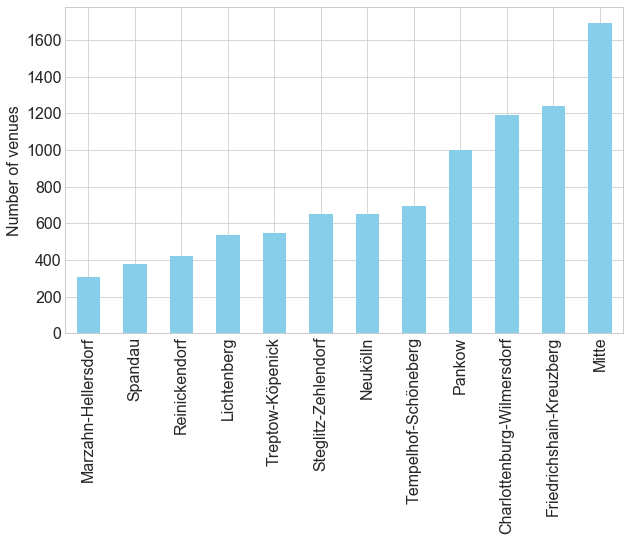

In [442]:
Dist_Counts = b_venues[['Venue ZIP', 'District']].groupby('District').count()
Dist_Counts=Dist_Counts.rename(columns={'Venue ZIP':'Number of Venues'})         
#Dist_Counts=Dist_Counts.reset_index()

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))
Dist_Counts['Number of Venues'].sort_values().plot(kind = 'bar', fontsize = 16, color = 'skyblue')


plt.ylabel('Number of venues',  fontsize = 16)
plt.xlabel('')

Let's put the number of returned venues per district into relationship to the number of people. 

Text(0.5, 0, '')

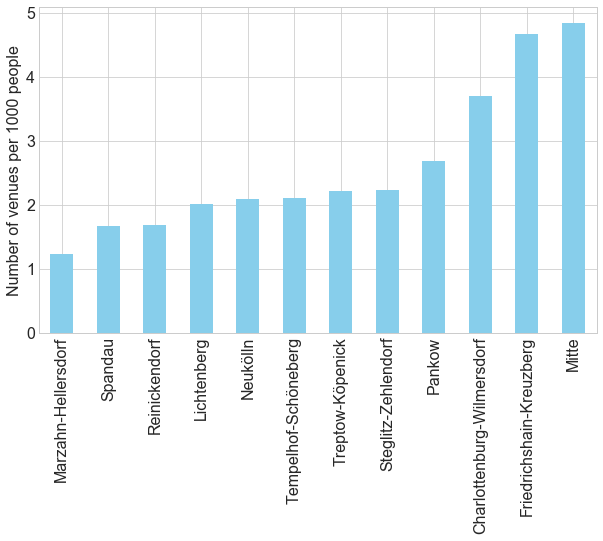

In [444]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))

df_DisVen = df_dem.copy()
df_DisVen=df_DisVen.merge(Dist_Counts, how = 'left', left_index=True, right_index=True)
#Dist_Counts=Dist_Counts.set_index('District')
df_DisVen['VenPerPop'] = df_DisVen['Number of Venues']/df_DisVen['Total']*1000


df_DisVen['VenPerPop'].sort_values().plot(kind = 'bar', fontsize = 16, color = 'skyblue')

plt.ylabel('Number of venues per 1000 people',  fontsize = 16)
plt.xlabel('')


In [510]:
df_dem_rel=df_dem_rel.merge(df_DisVen[['VenPerPop']], how = 'left', left_index=True, right_index=True)


Districts with higher fraction of younger adults have a higher density of shops.

Text(86.625, 0.5, 'Number of venues per 1000 people')

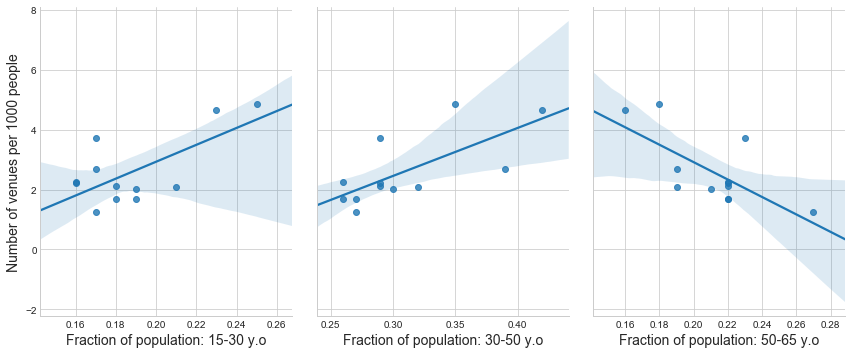

In [509]:
pp=sns.pairplot(df_dem_rel, x_vars=["15-30", "30-50", "50-65"], y_vars=["VenPerPop"],
             height=5, aspect=.8, kind="reg");

pp.axes[0,0].set_xlabel('Fraction of population: 15-30 y.o', fontsize = 14)
pp.axes[0,1].set_xlabel('Fraction of population: 30-50 y.o', fontsize = 14)
pp.axes[0,2].set_xlabel('Fraction of population: 50-65 y.o', fontsize = 14)

pp.axes[0,0].set_ylabel('Number of venues per 1000 people', fontsize = 14)

In [483]:
df_dem_rel

0-15_x  15-30_x  30-50_x  50-65_x  >65_x  \
District                                                               
Charlottenburg-Wilmersdorf    0.11     0.17     0.29     0.23   0.24   
Friedrichshain-Kreuzberg      0.14     0.23     0.42     0.16   0.11   
Lichtenberg                   0.14     0.19     0.30     0.21   0.21   
Marzahn-Hellersdorf           0.15     0.17     0.27     0.27   0.20   
Mitte                         0.14     0.25     0.35     0.18   0.14   
Neukölln                      0.14     0.21     0.32     0.19   0.19   
Pankow                        0.16     0.17     0.39     0.19   0.16   
Reinickendorf                 0.14     0.18     0.26     0.22   0.25   
Spandau                       0.15     0.19     0.27     0.22   0.23   
Steglitz-Zehlendorf           0.13     0.16     0.26     0.22   0.27   
Tempelhof-Schöneberg          0.13     0.18     0.29     0.22   0.22   
Treptow-Köpenick              0.13     0.16     0.29     0.22   0.24   

                            Number of Venues_x  0-15_y  15-30_y  30-50_y  \
District                                                                   
Charlottenburg-Wilmersdorf                1191   36786    55468    92473   
Friedrichshain-Kreuzberg                  1242   36943    61001   111795   
Lichtenberg                                537   37747    51450    80893   
Marzahn-Hellersdorf                        307   37236    42043    66718   
Mitte                                     1694   48760    86902   122995   
Neukölln                                   651   44075    65789   100401   
Pankow                                     999   58786    63553   143907   
Reinickendorf                              421   35930    43676    63644   
Spandau                                    379   33528    42010    60366   
Steglitz-Zehlendorf                        649   38732    46042    74803   
Tempelhof-Schöneberg                       696   43390    60065    96219   
Treptow-Köpenick                           545   32930    39901    72366   

                            50-65_y  >65_y   Total  Number of Venues_y  \
District                                                                 
Charlottenburg-Wilmersdorf    72484  77124  321045                1191   
Friedrichshain-Kreuzberg      43344  27993  265903                1242   
Lichtenberg                   55207  55424  265762                 537   
Marzahn-Hellersdorf           67071  48886  248323                 307   
Mitte                         61261  48204  349199                1694   
Neukölln                      60155  57625  311462                 651   
Pankow                        69218  59352  372086                 999   
Reinickendorf                 54959  62044  248073                 421   
Spandau                       49526  52848  226631                 379   
Steglitz-Zehlendorf           65097  77855  290136                 649   
Tempelhof-Schöneberg          73682  71668  329608                 696   
Treptow-Köpenick              53368  59217  245346                 545   

                            VenPerPop_x  VenPerPop_y  VenPerPop  
District                                                         
Charlottenburg-Wilmersdorf     3.709760     3.709760   3.709760  
Friedrichshain-Kreuzberg       4.670876     4.670876   4.670876  
Lichtenberg                    2.020605     2.020605   2.020605  
Marzahn-Hellersdorf            1.236293     1.236293   1.236293  
Mitte                          4.851102     4.851102   4.851102  
Neukölln                       2.090143     2.090143   2.090143  
Pankow                         2.684863     2.684863   2.684863  
Reinickendorf                  1.697081     1.697081   1.697081  
Spandau                        1.672322     1.672322   1.672322  
Steglitz-Zehlendorf            2.236882     2.236882   2.236882  
Tempelhof-Schöneberg           2.111599     2.111599   2.111599  
Treptow-Köpenick               2.221353     2.221353   2.22

**For subsequent analysis by postcode area we create a datafame with representative coordinates for each postcode**

In [455]:
# Calculate mean and area for each zipcode
import pyproj
from functools import partial
import shapely.ops as ops

with open(berlinZIP_json, encoding = 'utf-8') as json_file:  
    js = json.load(json_file)

area = []
lats = []
lons = []
name = []

for feature in js['features']:
        name.append(feature['properties']['spatial_name'])
        polygon = shape(feature['geometry'])
        p=polygon.representative_point()
        lons.append(p.x)
        lats.append(p.y)
        
        geom_aea = ops.transform(
            partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
            proj='aea',
            lat_1=polygon.bounds[1],
            lat_2=polygon.bounds[3])),
        polygon)
        a = geom_aea.area/1000**2
        area.append(a)
        #print(feature['properties']['spatial_name']) 
        #if polygon.contains(point):
            #print(feature['properties']['spatial_name'])
        #    zips[ct] = feature['properties']['spatial_name']       

        

ZIPS = pd.DataFrame(data={'ZIP':name, 'Latitude':lats, 'Longitude':lons, 'Area':area})
berlin_merged =ZIPS.merge(b_venues,how='left', left_on='ZIP', right_on='Venue ZIP')
berlin_merged.head()

ZIP   Latitude  Longitude      Area                  District  \
0  10115  52.531967  13.383751  2.306919  Friedrichshain-Kreuzberg   
1  10115  52.531967  13.383751  2.306919                     Mitte   
2  10115  52.531967  13.383751  2.306919                     Mitte   
3  10115  52.531967  13.383751  2.306919                     Mitte   
4  10115  52.531967  13.383751  2.306919                     Mitte   

   District Latitude  District Longitude  \
0          52.499656           13.433693   
1          52.525822           13.373797   
2          52.525822           13.373797   
3          52.525822           13.373797   
4          52.525822           13.373797   

                                       Venue  Venue Latitude  Venue Longitude  \
0                                   Khartoum       52.498872        13.428059   
1                      Museum für Naturkunde       52.530271        13.379281   
2  Adina Apartment Hotel Berlin Hauptbahnhof       52.528358        13.377940   
3                   miniloft Apartment Hotel       52.529175        13.379861   
4                            Kieser Training       52.527710        13.380897   

                                       Venue address Venue City Venue ZIP  \
0        [Wiener Str. 64, 10115 Berlin, Deutschland]     Berlin     10115   
1      [Invalidenstr. 43, 10115 Berlin, Deutschland]     Berlin     10115   
2  [Platz vor dem Neuen Tor 6, 10115 Berlin, Deut...     Berlin     10115   
3      [Hessische Str. 5, 10115 Berlin, Deutschland]     Berlin     10115   
4  [Hannoversche Str. 19, 10115 Berlin, Deutschland]     Berlin     10115   

         Venue Category         Venue Category ID  
0    African Restaurant  4bf58dd8d48988d1c8941735  
1        Science Museum  4bf58dd8d48988d191941735  
2                 Hotel  4bf58dd8d48988d1fa931735  
3                 Hotel  4bf58dd8d48988d1fa931735  
4  Gym / Fitness Center  4bf58dd8d48988d175941735

In [ ]:
berlin_merged =ZIPS.merge(b_venues,how='left', left_on='ZIP', right_on='Venue ZIP')
berlin_merged.head()

And visualize each PostCode area with its number of shops

In [511]:

map_berlin_ven = folium.Map(location=[52.5200, 13.4050], zoom_start=10)
map_berlin_ven.choropleth(
    geo_data=berlinZIP_json,
    data=ZIP_Counts,
    columns=['Venue ZIP', 'Number of Venues'],
    key_on='feature.properties.spatial_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Venues',
    threshold_scale=[0,50,50,100,200,300]
)
map_berlin_ven.save(r'./Figures/map_venue.html')    
map_berlin_ven

### Clustering of Neigborhoods

Next we see, whether the PostCode areas - which correspond to _neighborhoods_ - compare with each other. For this we perfom clustering based on the venue types that are found. 

Since venue types are **categorical variables** we encode them as **dummy variables**. 

In [457]:

berlin_onehot = pd.get_dummies(b_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Neighborhood'] = b_venues['Venue ZIP'].astype(int).astype(str) 

berlin_onehot =ZIPS.merge(berlin_onehot,how='left', left_on='ZIP', right_on='Neighborhood')

# move neighborhood column to the first column
fixed_columns =  list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]


berlin_grouped = berlin_onehot.groupby('Neighborhood').mean().reset_index()
berlin_grouped.head()

Neighborhood   Latitude  Longitude      Area  ATM  Accessories Store  \
0        10115  52.531967  13.383751  2.306919  0.0                0.0   
1        10117  52.517391  13.388280  3.453212  0.0                0.0   
2        10119  52.530125  13.405510  0.976229  0.0                0.0   
3        10178  52.520296  13.404319  1.843709  0.0                0.0   
4        10179  52.513811  13.415286  2.196765  0.0                0.0   

   Adult Boutique  Afghan Restaurant  African Restaurant  Airport ...   \
0        0.000000                0.0            0.007143      0.0 ...    
1        0.000000                0.0            0.000000      0.0 ...    
2        0.000000                0.0            0.000000      0.0 ...    
3        0.006329                0.0            0.000000      0.0 ...    
4        0.000000                0.0            0.000000      0.0 ...    

   Whisky Bar  Windmill  Wine Bar  Wine Shop  Winery  Wings Joint  \
0         0.0       0.0  0.007143   0.007143     0.0          0.0   
1         0.0       0.0  0.017986   0.000000     0.0          0.0   
2         0.0       0.0  0.013986   0.000000     0.0          0.0   
3         0.0       0.0  0.000000   0.000000     0.0          0.0   
4         0.0       0.0  0.000000   0.000000     0.0          0.0   

   Women's Store  Yemeni Restaurant  Yoga Studio  Zoo  
0            0.0                0.0     0.000000  0.0  
1            0.0                0.0     0.003597  0.0  
2            0.0                0.0     0.006993  0.0  
3            0.0                0.0     0.012658  0.0  
4            0.0                0.0     0.000000  0.0  

[5 rows x 457 columns]

We expect clusters to not fully separate, because we have a lot of sparse categories. And because Foursquare data is biased towards commercial venues, but select for now 4 clusters. 

In [463]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4

berlin_grouped_clustering = berlin_grouped.drop(['Neighborhood',  'Latitude', 'Longitude',  'Area' ], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [460]:
berlin_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
berlin_grouped.head()

Cluster Labels Neighborhood   Latitude  Longitude      Area  ATM  \
0               0        10115  52.531967  13.383751  2.306919  0.0   
1               0        10117  52.517391  13.388280  3.453212  0.0   
2               0        10119  52.530125  13.405510  0.976229  0.0   
3               0        10178  52.520296  13.404319  1.843709  0.0   
4               0        10179  52.513811  13.415286  2.196765  0.0   

   Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                0.0        0.000000                0.0            0.007143   
1                0.0        0.000000                0.0            0.000000   
2                0.0        0.000000                0.0            0.000000   
3                0.0        0.006329                0.0            0.000000   
4                0.0        0.000000                0.0            0.000000   

  ...   Whisky Bar  Windmill  Wine Bar  Wine Shop  Winery  Wings Joint  \
0 ...          0.0       0.0  0.007143   0.007143     0.0          0.0   
1 ...          0.0       0.0  0.017986   0.000000     0.0          0.0   
2 ...          0.0       0.0  0.013986   0.000000     0.0          0.0   
3 ...          0.0       0.0  0.000000   0.000000     0.0          0.0   
4 ...          0.0       0.0  0.000000   0.000000     0.0          0.0   

   Women's Store  Yemeni Restaurant  Yoga Studio  Zoo  
0            0.0                0.0     0.000000  0.0  
1            0.0                0.0     0.003597  0.0  
2            0.0                0.0     0.006993  0.0  
3            0.0                0.0     0.012658  0.0  
4            0.0                0.0     0.000000  0.0  

[5 rows x 458 columns]

In [466]:
berlin_merged =ZIPS[['ZIP']].merge(berlin_grouped,how='left', left_on='ZIP', right_on='Neighborhood')
berlin_merged.head()

ZIP  Cluster Labels Neighborhood   Latitude  Longitude      Area  ATM  \
0  10115               0        10115  52.531967  13.383751  2.306919  0.0   
1  10117               0        10117  52.517391  13.388280  3.453212  0.0   
2  10119               0        10119  52.530125  13.405510  0.976229  0.0   
3  10178               0        10178  52.520296  13.404319  1.843709  0.0   
4  10179               0        10179  52.513811  13.415286  2.196765  0.0   

   Accessories Store  Adult Boutique  Afghan Restaurant ...   Whisky Bar  \
0                0.0        0.000000                0.0 ...          0.0   
1                0.0        0.000000                0.0 ...          0.0   
2                0.0        0.000000                0.0 ...          0.0   
3                0.0        0.006329                0.0 ...          0.0   
4                0.0        0.000000                0.0 ...          0.0   

   Windmill  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0       0.0  0.007143   0.007143     0.0          0.0            0.0   
1       0.0  0.017986   0.000000     0.0          0.0            0.0   
2       0.0  0.013986   0.000000     0.0          0.0            0.0   
3       0.0  0.000000   0.000000     0.0          0.0            0.0   
4       0.0  0.000000   0.000000     0.0          0.0            0.0   

   Yemeni Restaurant  Yoga Studio  Zoo  
0                0.0     0.000000  0.0  
1                0.0     0.003597  0.0  
2                0.0     0.006993  0.0  
3                0.0     0.012658  0.0  
4                0.0     0.000000  0.0  

[5 rows x 459 columns]

Lets analyze the clusters further.

1. First by mapping them

In [470]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[52.5200, 13.4050], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_grouped['Latitude'], berlin_grouped['Longitude'],berlin_grouped['Neighborhood'], berlin_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters.save(r'./Figures/map_cluster.html')    
map_clusters

It looks like, we have a **central cluster** and then some **peripheral clusters**, but lets have a deeper look, by determining the most common venues for each cluster. 

In [467]:
# get most common venues
# display one example for each cluster 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [327]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = berlin_grouped['Neighborhood']


for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, 7:], num_top_venues)

neighborhoods_venues_sorted['Cluster Labels'] = berlin_grouped['Cluster Labels']
#neighborhoods_venues_sorted.head()


#### First cluster: Urban center

This cluster, located in the center of Berling is dominated by **_hotels, restaurants, cafes ..._** indicating commercial activity and urban dynamic living.

In [333]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==0].head(10)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0        10115                 Hotel           Coffee Shop   
1        10117                 Hotel     German Restaurant   
2        10119    Italian Restaurant                  Café   
3        10178                 Hotel            Restaurant   
4        10179                 Hotel             Nightclub   
5        10243                 Hotel                Bakery   
6        10245                  Café                   Bar   
7        10247                  Café                   Bar   
8        10249           Supermarket                Bakery   
9        10315           Supermarket              Bus Stop   

   3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0                   Café             Restaurant    Italian Restaurant   
1     Italian Restaurant                   Café           Art Gallery   
2  Vietnamese Restaurant                  Hotel           Coffee Shop   
3  Vietnamese Restaurant            Coffee Shop             Nightclub   
4                 Bakery       Sushi Restaurant                  Café   
5                 Hostel            Supermarket           Coffee Shop   
6            Coffee Shop  Vietnamese Restaurant             Nightclub   
7                 Bakery            Pizza Place    Italian Restaurant   
8                  Hotel  Vietnamese Restaurant                  Park   
9                 Bakery              Drugstore           Coffee Shop   

           6th Most Common Venue          7th Most Common Venue  \
0          Vietnamese Restaurant                         Bakery   
1                          Plaza                      Bookstore   
2                            Bar              French Restaurant   
3                 Clothing Store                           Café   
4                    Supermarket    Eastern European Restaurant   
5             Italian Restaurant                      Nightclub   
6  Vegetarian / Vegan Restaurant                   Cocktail Bar   
7                    Coffee Shop  Vegetarian / Vegan Restaurant   
8                 Ice Cream Shop                Organic Grocery   
9              Food & Drink Shop                        Stadium   

        8th Most Common Venue          9th Most Common Venue  \
0  Modern European Restaurant                         Museum   
1              Clothing Store                     Restaurant   
2              Breakfast Spot                       Beer Bar   
3         Indie Movie Theater                    Art Gallery   
4   Middle Eastern Restaurant                         Bistro   
5                 Event Space  Vegetarian / Vegan Restaurant   
6          Falafel Restaurant                         Bakery   
7                       Hotel                 Ice Cream Shop   
8                 Pizza Place                     Playground   
9                   Gastropub                  Big Box Store   

  10th Most Common Venue  Cluster Labels  
0     Falafel Restaurant               0  
1            Coffee Shop               0  
2                 Hostel               0  
3                 Museum               0  
4                  Plaza               0  
5                   Café               0  
6         Ice Cream Shop               0  
7      Indian Restaurant               0  
8                  Plaza               0  
9              Cafeteria               0

#### Second cluster: Respite from the city

This peripheral cluster looks a lot more residential featuring _**supermarkes, transit venues**_, but also  _**hotels, parks, lakes, marinas** and **even a nudist-beach**..._

We suppose that this is a more recreational area, which is also confimed by looking at the map, which shows forests and lakes nearby. 

In [334]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==1].head(10)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
107        12527          Tram Station       Harbor / Marina   
110        12559           Supermarket                  Lake   
112        12589                 Hotel                  Café   
132        13125           Supermarket                  Café   
179        14089           Supermarket              Bus Stop   
180        14109       Harbor / Marina     German Restaurant   
181        14129           Supermarket                 Plaza   
186        14193     German Restaurant    Italian Restaurant   

    3rd Most Common Venue 4th Most Common Venue       5th Most Common Venue  \
107                  Lake       Airport Service                       Hotel   
110     German Restaurant       Harbor / Marina                Tram Station   
112          Tram Station    Light Rail Station           German Restaurant   
132                Bakery              Bus Stop  Construction & Landscaping   
179      Insurance Office             Drugstore                 Beer Garden   
180                  Lake           Supermarket                    Bus Stop   
181    Italian Restaurant       Harbor / Marina                Intersection   
186              Bus Stop                  Lake                       Hotel   

          6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
107                 Gas Station           Sports Club                  Café   
110                         Bar         Bowling Alley             BBQ Joint   
112  Construction & Landscaping    Seafood Restaurant              Bus Stop   
132          Miscellaneous Shop               Dog Run    Light Rail Station   
179          Athletics & Sports     Trattoria/Osteria                  Pier   
180                      Bakery                Palace    Italian Restaurant   
181                       Beach                  Park            Restaurant   
186                       Plaza                  Café           Supermarket   

    9th Most Common Venue 10th Most Common Venue  Cluster Labels  
107           Gaming Cafe          Boat or Ferry               1  
110    Salon / Barbershop                 Bakery               1  
112          Nudist Beach                 Forest               1  
132                 Plaza           Liquor Store               1  
179       Harbor / Marina                 Bakery               1  
180           Art Gallery            Sports Club               1  
181         Grocery Store                    Bar               1  
186     Trattoria/Osteria                   Park               1

#### Third cluster: People live here

This second urban cluster is more residential compared to the **Urban center** with _**supermarkes and transit venues**_. But it does not feature many _**recreational** or **touristic venues**..._

These areas are also further away from the city center, but still densly built up.

In [335]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==2].head(10)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
11         10318          Tram Station           Supermarket   
13         10365           Supermarket          Tram Station   
68         12099           Supermarket             Drugstore   
83         12207              Bus Stop           Supermarket   
87         12277           Supermarket    Italian Restaurant   
93         12349           Supermarket                Garden   
96         12355    Italian Restaurant           Supermarket   
98         12359           Supermarket         Metro Station   
100        12437                Bakery           Supermarket   
102        12459                  Café         Train Station   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
11                  Bakery                  Café       Organic Grocery   
13   Vietnamese Restaurant                Bakery   Rental Car Location   
68                  Bakery   Fried Chicken Joint              Bus Stop   
83    Fast Food Restaurant                  Café                Bakery   
87                    Park  Fast Food Restaurant         Big Box Store   
93       German Restaurant            Restaurant    Italian Restaurant   
96              Playground              Bus Stop      Business Service   
98                    Park         Historic Site  Fast Food Restaurant   
100                 Forest              Bus Stop                  Café   
102           Tram Station                Forest           Supermarket   

     6th Most Common Venue         7th Most Common Venue  \
11                    Park            Light Rail Station   
13             Pizza Place          Gym / Fitness Center   
68   Vietnamese Restaurant                          Park   
83       German Restaurant                           Gym   
87                   Diner                      Bus Stop   
93               Pet Store                        Bakery   
96                  Garden                 Garden Center   
98              Playground             German Restaurant   
100              Drugstore                    Playground   
102     Italian Restaurant  Theme Park Ride / Attraction   

    8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  \
11       Doner Restaurant    Chinese Restaurant                    Drugstore   
13         Hardware Store      Greek Restaurant                Memorial Site   
68         Clothing Store      Asian Restaurant              Motorcycle Shop   
83              Drugstore    Chinese Restaurant  Eastern European Restaurant   
87     Light Rail Station           IT Services                         Bank   
93                   Park           Gas Station                        Field   
96       Greek Restaurant         Grocery Store                Metro Station   
98                 Bakery          Soccer Field           Chinese Restaurant   
100                  Pier         Garden Center                  Gas Station   
102     German Restaurant           Gas Station                       Bakery   

     Cluster Labels  
11                2  
13                2  
68                2  
83                2  
87                2  
93                2  
96                2  
98                2  
100               2  
102               2

#### Fourth cluster: The city's edge

This peripheral cluster lacks the attractions of the **second cluster**, but has venues, which indicate lower denisty such as **_parks, fairs, farms**_, but **_hotels, forests_** and **_lakes_** are missing.   


In [336]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==3].head(10)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
111        12587          Tram Station     German Restaurant   
115        12623           Supermarket              Bus Stop   
120        12683           Supermarket    Italian Restaurant   
133        13127          Tram Station           Supermarket   
137        13159                  Café              Bus Stop   
157        13503      Insurance Office           Supermarket   
164        13587           Supermarket         Boat or Ferry   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
111                  Café    Light Rail Station                Bakery   
115          Tram Station      Greek Restaurant    Light Rail Station   
120         Metro Station             Drugstore    Light Rail Station   
133                 Hotel              Bus Stop          Liquor Store   
137              Mountain               Dog Run      Botanical Garden   
157    Italian Restaurant    Light Rail Station            Restaurant   
164              Bus Stop            Restaurant                Forest   

    6th Most Common Venue 7th Most Common Venue   8th Most Common Venue  \
111                Forest           Supermarket                    Park   
115            Restaurant  Fast Food Restaurant  Furniture / Home Store   
120                  Park             Pet Store                   Train   
133        Hardware Store                  Farm           Garden Center   
137    Miscellaneous Shop        Clothing Store                    Fair   
157              Bus Stop                Forest             Gas Station   
164                  Lake               Stadium         Nature Preserve   

    9th Most Common Venue 10th Most Common Venue  Cluster Labels  
111       Organic Grocery      Food & Drink Shop               3  
115                Bakery     Italian Restaurant               3  
120      Greek Restaurant          Shopping Mall               3  
133    Chinese Restaurant            Gas Station               3  
137    Falafel Restaurant                   Farm               3  
157                  Park      German Restaurant               3  
164           Gas Station             Campground               3

## The Pulse of Berlin: Trending Venues

The below code was deployed on **IBM Watson Studio** and executed hourly to get a dataframe of trending venues, which was _pickled_ to file for later analysis of trending venues.

The code was run from Thursday May-2-2019 00:00 EST to Monday May-7-2019 4:00 EST providing information about trending venues for several workdays and a weekend. 

In [13]:
# Credentials were removed for privacy
credentials = {
    'IAM_SERVICE_ID': '...',
    'IBM_API_KEY_ID': '...',
    'ENDPOINT': '...',
    'IBM_AUTH_ENDPOINT': '...',
    'BUCKET': '...',
    'FILE': 'Points.pkl'
}

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3


from ibm_botocore.client import Config
import ibm_boto3

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')


download_file_cos(credentials,'Points.pkl','Points.pkl')

# define URL

RADIUS = 2000
LIMIT = 50

import time
import datetime

def get_trending(lat, lon): 
    results_df = pd.DataFrame()
    for latitude, longitude in zip(lat, lon):   
        url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, RADIUS, LIMIT)

        # send GET request and get trending venues
        results = requests.get(url).json()
        results
        if not results['response']:
            print(results['meta']['errorDetail'])   
        elif not len(results['response']['venues']) == 0:
            print('Trending: Lat={},Lon={}'.format(latitude, longitude))
        
            trending_venues = results['response']['venues']
            trending_venues_df = json_normalize(trending_venues)
        
            if results_df.empty:
                results_df =  trending_venues_df
            else:
                results_df = pd.concat([results_df, trending_venues_df], ignore_index =True) 
        else:
            print('No Trending: Lat={},Lon={}'.format(latitude, longitude)) 
        
    return results_df

start = time.time()

df_points= pd.read_pickle('./Points.pkl')
      
latitude = list(df_points.Latitude)
longitude = list(df_points.Longitude)      
      
results_df = get_trending(latitude,longitude)    

tstr = datetime.datetime.utcnow().strftime("%Y%m%d_%H")        
results_df.to_pickle('./Trending_{}.pkl'.format(tstr))
end = time.time()
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d %H")
    
    #numrec = results_df.shape
with open('Log.txt', 'a') as f: 
     f.write('{}: Read {} records in {:} s'.format(now, len(results_df), end-start)) 

from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])



# Upload file wine.csv from wine folder into project bucket as wine_data.csv
cos.upload_file(Filename='Log.txt',Bucket=credentials['BUCKET'],Key='Log_{}.csv'.format(tstr))
# upload zip file

# Upload pickle object
cos.upload_file('Trending_{}.pkl'.format(tstr), credentials['BUCKET'],'Trending_{}.pkl'.format(tstr))

No Trending: Lat=52.53377241998363,Lon=13.299782617466867
No Trending: Lat=52.48027401390051,Lon=13.331298777260578
No Trending: Lat=52.47899521165658,Lon=13.24299182100738
No Trending: Lat=52.47855430317942,Lon=13.213557664219715
No Trending: Lat=52.49824679655834,Lon=13.330618242753369
No Trending: Lat=52.49782757964201,Lon=13.301169864772941
No Trending: Lat=52.47985506744023,Lon=13.30186239016174
No Trending: Lat=52.49740103691055,Lon=13.271722218624591
No Trending: Lat=52.49652597568962,Lon=13.212829172432865
No Trending: Lat=52.5162195180819,Lon=13.329936989068434
No Trending: Lat=52.51580003048978,Lon=13.30047660755174
No Trending: Lat=52.515373212357765,Lon=13.271016958898384
No Trending: Lat=52.51493906410644,Lon=13.241558055778851
No Trending: Lat=52.496967168783996,Lon=13.242275316961008
No Trending: Lat=52.479428799885746,Lon=13.272426733865696
No Trending: Lat=52.5178241548914,Lon=13.447785590290087
No Trending: Lat=52.49906325130132,Lon=13.389517143589796
No Trending: Lat

No Trending: Lat=52.514048778964316,Lon=13.182642536813043
No Trending: Lat=52.42373688482418,Lon=13.156944302102241
No Trending: Lat=52.444739359311676,Lon=13.362070852163322
No Trending: Lat=52.44432826518054,Lon=13.332657692785961
No Trending: Lat=52.42280563704129,Lon=13.09815323497688
No Trending: Lat=52.423274913102546,Lon=13.127548366945875
No Trending: Lat=52.426766128160025,Lon=13.362737281169027
No Trending: Lat=52.424638913441036,Lon=13.215738531688766
No Trending: Lat=52.42507896945044,Lon=13.245136800969476
No Trending: Lat=52.42551171934849,Lon=13.274535823138725
No Trending: Lat=52.42593716271018,Lon=13.303935585616639
No Trending: Lat=52.426355299117596,Lon=13.33333607582135
No Trending: Lat=52.44390985897438,Lon=13.303245249557271
No Trending: Lat=52.408382271918846,Lon=13.334013743713449
No Trending: Lat=52.407964405091704,Lon=13.304625193948883
No Trending: Lat=52.407539236016014,Lon=13.275237370889714
No Trending: Lat=52.42419155175251,Lon=13.186341027874429
No Tren

Empty DataFrame
Columns: []
Index: []

### Starting the analysis 

We first read the data in from file. 

Note that some files failed to generate, this may have been due to downtime on Watson Studio or other issues. My theory is a consistency issue with the Foursquare API: Not all venues have postcodes associated with them (the postalCode variable is missing), and I failed to account for that in my code, causing the script to fail. 

For the purpose of this work, we assume that no-file means that no trending venues were found. 

In [1]:
import glob
Files = glob.glob(r'./Data/Trending/Trending_20190*.pkl')
Files[0:5]

['./Data/Trending\\Trending_20190502_0000.pkl',
 './Data/Trending\\Trending_20190502_0200.pkl',
 './Data/Trending\\Trending_20190502_0300.pkl',
 './Data/Trending\\Trending_20190502_0400.pkl',
 './Data/Trending\\Trending_20190502_0500.pkl']

In [2]:
import pandas as pd
import numpy as np

df_trending = pd.DataFrame(columns = ['Date', 'Hour', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude', 'Venue City'])
for file in Files:
    df = pd.read_pickle(file)
    #print(file)
    for index, row in df.iterrows():  
        try: 
            city = row['location.city']
        except:
            city = []
                  
        df_trending=df_trending.append({'Date' : file[25:33], 
                            'Hour' : file[34:36],
                            'Venue Name': row['name'], 
                            'Venue Latitude' : row['location.lat'],
                            'Venue Longitude': row['location.lng'], 
                            'Venue Category': row['categories'][0]['pluralName'],
                            'Venue City': city}, 
                             ignore_index=True)
        
df_trending.head()      

Date Hour                                         Venue Name  \
0  20190502   00                                 Matrix Club Berlin   
1  20190502   00                                 Matrix Club Berlin   
2  20190502   00                                 Matrix Club Berlin   
3  20190502   06  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
4  20190502   06  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   

  Venue Category  Venue Latitude  Venue Longitude Venue City  
0     Nightclubs       52.504715        13.449293     Berlin  
1     Nightclubs       52.504715        13.449293     Berlin  
2     Nightclubs       52.504715        13.449293     Berlin  
3       Airports       52.554516        13.293071     Berlin  
4       Airports       52.554516        13.293071     Berlin

Since we have overlap between points, we remove duplicates and add a proper timestamp.

In [3]:
df_trending= df_trending.drop_duplicates(subset=['Date','Hour','Venue Name'], keep='first')
df_trending['Time'] = df_trending['Date'].map(str) + df_trending['Hour']
df_trending['Time']=pd.to_datetime(df_trending['Time'], format="%Y%m%d%H")
df_trending.shape

(350, 8)

Let's see what is trending!

In [16]:
df_trending['Venue Category'].value_counts()

Airports                      123
Train Stations                 31
Event Spaces                   20
Soccer Stadiums                13
Outdoor Event Spaces           13
Parks                          11
Conferences                    10
Auditoriums                     9
Beer Bars                       7
Advertising Agencies            7
Coffee Shops                    7
Flea Markets                    6
Monuments / Landmarks           6
Rock Clubs                      5
Zoos                            5
Assisted Living                 5
Breweries                       4
Food Courts                     4
Prisons                         4
Gourmet Shops                   4
Asian Restaurants               4
Middle Eastern Restaurants      3
Fried Chicken Joints            3
Bavarian Restaurants            3
Beer Gardens                    3
Dance Studios                   3
Currywurst Joints               3
Historic Sites                  3
Hotels                          2
Plazas        

In [19]:
df_trending[df_trending['Venue Category']=='Advertising Agencies']

Date Hour            Venue Name        Venue Category  \
173  20190503   09                  TLGG  Advertising Agencies   
183  20190503   10                  TLGG  Advertising Agencies   
898  20190506   19  fischerAppelt Berlin  Advertising Agencies   
917  20190506   20  fischerAppelt Berlin  Advertising Agencies   
930  20190506   21  fischerAppelt Berlin  Advertising Agencies   
938  20190506   22  fischerAppelt Berlin  Advertising Agencies   
941  20190506   23  fischerAppelt Berlin  Advertising Agencies   

     Venue Latitude  Venue Longitude Venue City                Time  \
173       52.496302        13.422546     Berlin 2019-05-03 09:00:00   
183       52.496302        13.422546     Berlin 2019-05-03 10:00:00   
898       52.539277        13.411870     Berlin 2019-05-06 19:00:00   
917       52.539277        13.411870     Berlin 2019-05-06 20:00:00   
930       52.539277        13.411870     Berlin 2019-05-06 21:00:00   
938       52.539277        13.411870     Berlin 2019-05-06 22:00:00   
941       52.539277        13.411870     Berlin 2019-05-06 23:00:00   

    Venue Groups  
173     Business  
183     Business  
898     Business  
917     Business  
930     Business  
938     Business  
941     Business

In [20]:
df_trending[df_trending['Venue Category']=='Prisons']

Date Hour              Venue Name Venue Category  Venue Latitude  \
166  20190503   08  Hohenshönhausen Prison        Prisons       52.541885   
175  20190503   09  Hohenshönhausen Prison        Prisons       52.541885   
185  20190503   10  Hohenshönhausen Prison        Prisons       52.541885   
199  20190503   11  Hohenshönhausen Prison        Prisons       52.541885   

     Venue Longitude Venue City                Time Venue Groups  
166        13.501736        NaN 2019-05-03 08:00:00        Other  
175        13.501736        NaN 2019-05-03 09:00:00        Other  
185        13.501736        NaN 2019-05-03 10:00:00        Other  
199        13.501736        NaN 2019-05-03 11:00:00        Other

In [22]:
df_trending[df_trending['Venue Category']=='Assisted Living']

Date Hour Venue Name   Venue Category  Venue Latitude  \
764  20190506   08     rp19wg  Assisted Living       52.485444   
780  20190506   09     rp19wg  Assisted Living       52.485444   
946  20190507   01     rp19wg  Assisted Living       52.485444   
948  20190507   02     rp19wg  Assisted Living       52.485444   
950  20190507   03     rp19wg  Assisted Living       52.485444   

     Venue Longitude Venue City                Time Venue Groups  
764        13.361353     Berlin 2019-05-06 08:00:00     Business  
780        13.361353     Berlin 2019-05-06 09:00:00     Business  
946        13.361353     Berlin 2019-05-07 01:00:00     Business  
948        13.361353     Berlin 2019-05-07 02:00:00     Business  
950        13.361353     Berlin 2019-05-07 03:00:00     Business

In [23]:
df_trending[df_trending['Venue Category']=='Currywurst Joints']

Date Hour Venue Name     Venue Category  Venue Latitude  \
693  20190505   19   Curry 36  Currywurst Joints       52.506508   
706  20190505   20   Curry 36  Currywurst Joints       52.506508   
719  20190505   21   Curry 36  Currywurst Joints       52.506508   

     Venue Longitude Venue City                Time Venue Groups  
693        13.332546     Berlin 2019-05-05 19:00:00  Restaurants  
706        13.332546     Berlin 2019-05-05 20:00:00  Restaurants  
719        13.332546     Berlin 2019-05-05 21:00:00  Restaurants

In [24]:
df_trending[df_trending['Venue Category']=='Doner Restaurants']

Date Hour      Venue Name     Venue Category  Venue Latitude  \
944  20190507   00  Meshur Köfteçi  Doner Restaurants       52.481663   

     Venue Longitude Venue City       Time Venue Groups  
944        13.349111         [] 2019-05-07  Restaurants

There are a lot of different venue types. We can manually refine this. I went through the list and grouped venues based on categories. There might be an automated way, but this was probably faster!

In [14]:
Map = {
"Event Spaces" : "Events","Soccer Stadiums" : "Events", "Outdoor Event Spaces" :"Events", "Parks" : "Outdoors" ,
"Conferences" :"Meetings", "Auditoriums" : "Meetings" , "Beer Bars" : "Bars", "Advertising Agencies" : "Business",           
"Monuments / Landmarks" : "Landmarks", "Flea Markets" : "Events", "Rock Clubs" : "Clubs",                        
"Zoos" : "Outdoors", "Assisted Living" : "Business", "Gourmet Shops" :"Shops" , "Prisons": "Other",
"Breweries" :  "Bars" , "Asian Restaurants" : "Restaurants" , "Food Courts" : "Restaurants",                   
"Beer Gardens" :  "Bars", "Historic Sites" : "Landmarks", "Middle Eastern Restaurants" : "Restaurants", "Dance Studios" : "Business",
"Bavarian Restaurants" : "Restaurants", "Fried Chicken Joints" : "Restaurants", "Currywurst Joints" : "Restaurants",
"Light Rail Stations"   : "Train Stations" , "Travel Lounges" : "Airports" , "Breakfast Spots" : "Restaurants" ,                                         
"Plazas" : "Outdoors", "Italian Restaurants" : "Restaurants", "Department Stores" : "Shops" ,
"Farmers Markets" : "Events", "Airport Terminals" : "Airports" , "Indie Movie Theaters":  "Other" ,
"Doner Restaurants" : "Restaurants", "Metro Stations" : "Train Stations", "History Museums": "Museums",   
"Shopping Malls" : "Shops", "Buildings":  "Other", "Neighborhoods": "Other", "Nightclubs " : "Clubs",  
"Concert Halls" : "Clubs", "Science Museums": "Museums", "Bridges" : "Outdoors", "Islands" : "Outdoors" ,
"Platforms" : "Train Stations", "Festivals" : "Events", "Nightclubs" : "Clubs"}

df_trending['Venue Groups'] = df_trending['Venue Category'] 
df_trending['Venue Groups'] = df_trending['Venue Groups'].replace(Map) 
df_trending

Date Hour                                         Venue Name  \
0    20190502   00                                 Matrix Club Berlin   
3    20190502   06  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
6    20190502   07                                Berlin Hauptbahnhof   
10   20190502   07  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
13   20190502   08                                Berlin Hauptbahnhof   
17   20190502   08  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
20   20190502   08  Berlin-Schönefeld Airport (SXF) (Flughafen Ber...   
21   20190502   09                                Berlin Hauptbahnhof   
25   20190502   09  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
28   20190502   09  Berlin-Schönefeld Airport (SXF) (Flughafen Ber...   
29   20190502   10                          KaDeWe Feinschmeckeretage   
31   20190502   10                                Berlin Hauptbahnhof   
35   20190502   10                                     Alexanderplatz   
38   20190502   10  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
42   20190502   10  Berlin-Schönefeld Airport (SXF) (Flughafen Ber...   
43   20190502   11                          KaDeWe Feinschmeckeretage   
45   20190502   11                                            Vapiano   
48   20190502   11  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
52   20190502   11  Berlin-Schönefeld Airport (SXF) (Flughafen Ber...   
53   20190502   12                          KaDeWe Feinschmeckeretage   
55   20190502   12                                            Vapiano   
58   20190502   12  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
62   20190502   13                          KaDeWe Feinschmeckeretage   
64   20190502   13                                         Terminal C   
68   20190502   14  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
71   20190502   15                                        S Grunewald   
75   20190502   15                                  Brandenburger Tor   
77   20190502   15  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
80   20190502   15  Berlin-Schönefeld Airport (SXF) (Flughafen Ber...   
81   20190502   16                                        S Grunewald   
..        ...  ...                                                ...   
872  20190506   17                                    Kühlhaus Berlin   
873  20190506   17                                       Museumsinsel   
876  20190506   17  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
882  20190506   17  Berlin-Schönefeld Airport (SXF) (Flughafen Ber...   
883  20190506   18                                     STATION-Berlin   
884  20190506   18                                 The Digital Eatery   
885  20190506   18                                           Lawrence   
890  20190506   18  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
894  20190506   18  Berlin-Schönefeld Airport (SXF) (Flughafen Ber...   
895  20190506   19                                     STATION-Berlin   
896  20190506   19                                 The Digital Eatery   
897  20190506   19                               Stage 1 | re:publica   
898  20190506   19                               fischerAppelt Berlin   
899  20190506   19                                           Lawrence   
900  20190506   19                                             Kaschk   
910  20190506   19  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
915  20190506   20                                 The Digital Eatery   
916  20190506   20                                     STATION-Berlin   
917  20190506   20                               fischerAppelt Berlin   
918  20190506   20                                           Lawrence   
925  20190506   20  Flughafen Berlin-Tegel Otto Lilienthal (TXL) (...   
929  20190506   21                                 The Digital Eatery   
930  20190506   21                               fischerAppelt Berl

We can now visualize that!

Text(0, 0.5, 'Numer of Trending Venues')

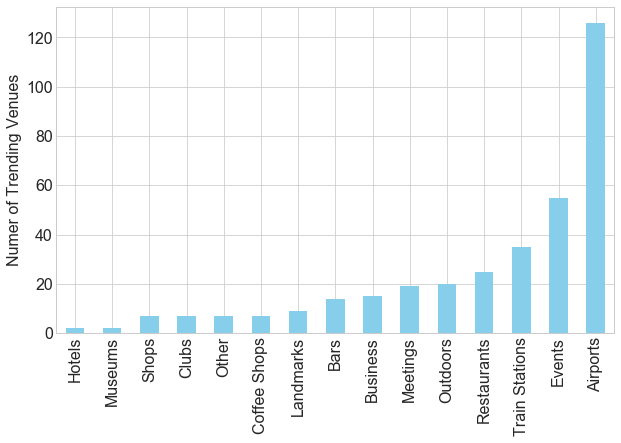

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))

df_trending['Venue Groups'].value_counts(ascending = True).plot(kind = 'bar', color = 'skyblue', fontsize = 16)
plt.ylabel('Numer of Trending Venues', fontsize = 16)

And how venues are trending over the course of the day!

Text(0.5, 0, 'Berlin Local Time (h)')

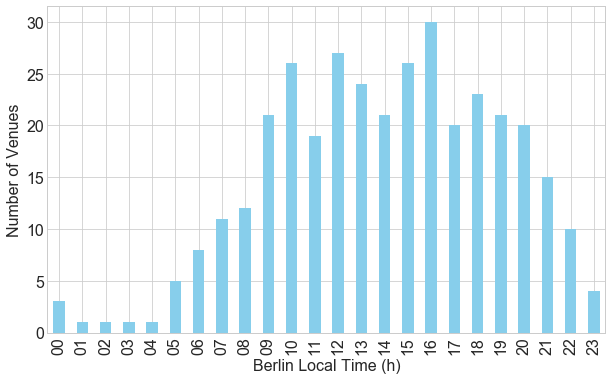

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))

df_trending['Hour'].value_counts().sort_index().plot(kind = 'bar', color =  'skyblue', fontsize = 16)
plt.ylabel('Number of Venues',fontsize = 16)
plt.xlabel('Berlin Local Time (h)',fontsize = 16)

It might also be interesting to see how different venue types trend over the course of the period. For that we separate the venue types and create a dataframe with cumulative sums.

In [8]:
trending = df_trending[['Time','Venue Groups']].set_index('Time')
trending = pd.get_dummies(trending[['Venue Groups']])
new_cols = [val[1] for val in trending.columns.str.split("_")]
new_cols
trending.columns = new_cols
trending = trending.cumsum()
trending.head()

Airports  Bars  Business  Clubs  Coffee Shops  Events  \
Time                                                                         
2019-05-02 00:00:00         0     0         0      1             0       0   
2019-05-02 06:00:00         1     0         0      1             0       0   
2019-05-02 07:00:00         1     0         0      1             0       0   
2019-05-02 07:00:00         2     0         0      1             0       0   
2019-05-02 08:00:00         2     0         0      1             0       0   

                     Hotels  Landmarks  Meetings  Museums  Other  Outdoors  \
Time                                                                         
2019-05-02 00:00:00       0          0         0        0      0         0   
2019-05-02 06:00:00       0          0         0        0      0         0   
2019-05-02 07:00:00       0          0         0        0      0         0   
2019-05-02 07:00:00       0          0         0        0      0         0   
2019-05-02 08:00:00       0          0         0        0      0         0   

                     Restaurants  Shops  Train Stations  
Time                                                     
2019-05-02 00:00:00            0      0               0  
2019-05-02 06:00:00            0      0               0  
2019-05-02 07:00:00            0      0               1  
2019-05-02 07:00:00            0      0               1  
2019-05-02 08:00:00            0      0               2

Text(0, 0.5, 'Total Trending')

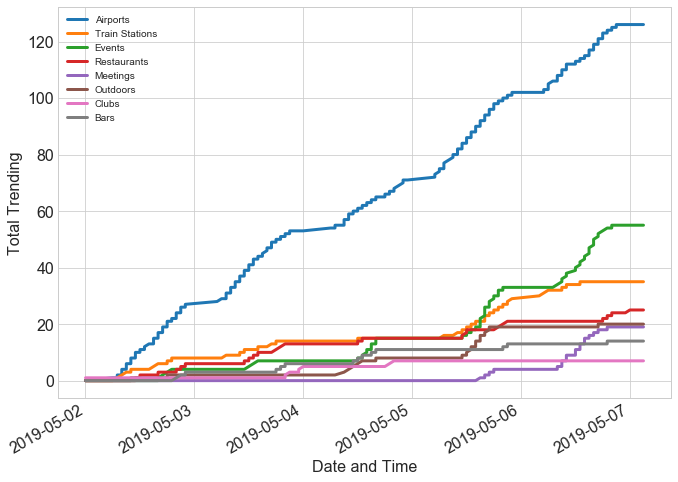

In [9]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(11,8) 

trending[['Airports', 'Train Stations', 'Events', 'Restaurants', 'Meetings', 'Outdoors', 'Clubs','Bars']].plot(ax =ax,
                                        kind = 'line', fontsize = 16, linewidth=3)
plt.xlabel('Date and Time', fontsize = 16)
plt.ylabel('Total Trending', fontsize = 16)

Finally lets create folium maps and save them png to create an anmiation (outside the notebook) of trending venues with time. We chose a 3-hour timestep.

In [282]:
import folium 
import time 

import selenium.webdriver
driver = selenium.webdriver.PhantomJS()
driver.set_window_size(4000/4, 3000/4) 

times = pd.date_range(start ='2019-05-02',  
         end ='2019-05-08', freq ='3H')
ct = 1
for t in  times :
    dt = pd.Timedelta(3,'h')
    trending = df_trending[(df_trending['Time']>=t) & (df_trending['Time'] < (t+dt)) ]
    
    map_berlin_trend = folium.Map(location=[52.5200, 13.4050], zoom_start=10)    
    
    for lat, lon, poi in zip(trending['Venue Latitude'], trending['Venue Longitude'] , trending['Venue Name']): 
        label = folium.Popup(str(poi) , parse_html=True)
        folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_berlin_trend)
        
    
    
    # Add a legend
    legend_html =   '''
                <div align="center" style="position: fixed; 
                            bottom: 630px; left: 600px; width: 400px; height: 90px; 
                            z-index:9999; font-size:22px;
                            ">&nbsp; {} <br>
                </div>
                '''.format(t.strftime('%A - %B %d, %Y %H:%M')) 

    map_berlin_trend.get_root().html.add_child(folium.Element(legend_html))

    map_berlin_trend.save('Trending.html')      
                          

    driver.get('Trending.html')
    # You may need to add time.sleep(seconds) here
    driver.save_screenshot('./Figures/Trending/N_Trending_{:02d}.png'.format(ct))
     
    ct = ct+1

    


In [13]:
import folium 
import time 

import selenium.webdriver
driver = selenium.webdriver.PhantomJS()
driver.set_window_size(4000/4, 3000/4) 
map_berlin_trend = folium.Map(location=[52.5200, 13.4050], zoom_start=10)  
for lat, lon, poi in zip(df_trending['Venue Latitude'], df_trending['Venue Longitude'] , df_trending['Venue Name']): 
        label = folium.Popup(str(poi) , parse_html=True)
        folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_berlin_trend)

map_berlin_trend

### Final Note 
This work was completed as part of a course on **Coursera** called [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone/). 

Empty DataFrame
Columns: [Date, Hour, Venue Name, Venue Category, Venue Latitude, Venue Longitude, Venue City, Time, Venue Groups]
Index: []